In [1]:
# Peter Nelson 5/1/19
# Code for use at the FASTBLADE facility, determining where and at what angle to place inclined hydraulic rams to best
# simulate desired loading in two dimensions. Desired loading distributions are integrated to give target shear and bending 
# distributions. A dual annealing SciPy solver is implemented to minimise an objective function describing the discrepancy 
# between the sum of the target and achieved shear distributions for both dimensions. Upper and Lower Bounds can be 
# specified as required.

# Start

In [2]:
import pandas as pd
import numpy as np
import scipy, datetime, math
from scipy import integrate
import matplotlib.pyplot as plt
%matplotlib inline  

data = pd.read_excel(r"C:\Users\Peter's 2nd Laptop\Documents\MATLAB\FB again\Matlab Code No Contraints\testdata.xlsx")

number_rams = 3
nodes = 50
lower_b = 0.1
upper_b = 0.95

# Interpolation

In [3]:
L = data['radial position'][len(data)-1]

x = list(range(0,nodes))
b = L/(nodes-1)
x[:] = [ __ * b for __ in x]

Fx = np.interp(x,data['radial position'],data['Fx'])              
Fy = np.interp(x,data['radial position'],data['Fy'])              

# Defining Targets

In [4]:
def targets(load):

    integralpart = scipy.integrate.cumtrapz(load, x)
    integralpart = np.insert(integralpart,0,0)
    TF = integralpart[-1]

    TargetShear = [None]*len(load)
    TargetShear[0] = TF

    for k in range(1,len(integralpart)):
        TargetShear[k] = TF-integralpart[k]

    integralPart = scipy.integrate.cumtrapz(TargetShear,x)
    integralPart = np.insert(integralPart,0,0)
    bmax = integralPart[-1]

    TargetBending = [None]*len(load)
    TargetBending[0] = -bmax

    for k in range(1,len(integralPart)):
        TargetBending[k] = integralPart[k]-bmax
        
    return TargetShear,TargetBending, TF, bmax

In [5]:
TargetShearx,TargetBendingx, TFx, bmaxx = targets(Fx)
TargetSheary,TargetBendingy, TFy, bmaxy = targets(Fy)
F = TFy/number_rams
Fvec = [F]*number_rams

# Actual Shear & Bending for Angled Loading

In [6]:
def angledF(avec):
          
    Fx = [None]*len(avec)
    Fy = [None]*len(avec)
    
    for i in range(0,len(avec)):
        Fx[i] = Fvec[i]*math.sin(math.radians(avec[i]))
        Fy[i] = Fvec[i]*math.cos(math.radians(avec[i]))
        
    return Fx,Fy

In [7]:
def AcSh2D(longsol):
        
    mid = int(number_rams)
    avec = longsol[0:mid]
    lvec = longsol[mid:mid*2]
    
    Fx,Fy = angledF(avec)
    
    ActualShearx = [TFx]*len(x)
    ActualSheary = [TFy]*len(x)
    
    for i in range(0,len(x)):
        for j in range(0,len(lvec)):
            if x[i] > lvec[j]:
                ActualShearx[i] = ActualShearx[i]-Fx[j]
                ActualSheary[i] = ActualSheary[i]-Fy[j]    
    
    return ActualSheary, ActualShearx

In [8]:
def AcBe(AcShy, AcShx):
    
    integralParty = scipy.integrate.cumtrapz(AcShy,x)
    integralParty = np.insert(integralParty,0,0)
    bmaxy = integralParty[-1]
    
    ActualBendingy = [None]*len(Fx)
    ActualBendingy[0] = -bmaxy

    for k in range(1,len(integralParty)):
        ActualBendingy[k] = integralParty[k]-bmaxy
        
    integralPartx = scipy.integrate.cumtrapz(AcShx,x)
    integralPartx = np.insert(integralPartx,0,0)
    bmaxy = integralPartx[-1]
    
    ActualBendingx = [None]*len(Fx)
    ActualBendingx[0] = -bmaxx

    for k in range(1,len(integralPartx)):
        ActualBendingx[k] = integralPartx[k]-bmaxx
        
    
    return(ActualBendingy,ActualBendingx)

# Objective Function

In [9]:
def obj(longsol):
    
    if len(longsol) != number_rams*2:
        print('wrong number of rams')
        # could add a condition where sol is ran with filled in 0s
        
    else:      
        lsq_l = [None]*(len(x))
        ActualSheary, ActualShearx  = AcSh2D(longsol)
        for i in range(0,len(x)):
            lsq_l[i] = abs(ActualSheary[i]-TargetSheary[i]) + abs(ActualShearx[i]-TargetShearx[i])
        
        return sum(lsq_l)

# Solver

In [13]:
bounds = [(0,90)]*number_rams + [(lower_b*L, upper_b*L)]*number_rams
solfinal = scipy.optimize.dual_annealing(obj,bounds, maxiter=5000)  # consider random state since same obj func found

n = np.sort(solfinal.x)
angles = n[0:int(number_rams)]
positions = n[int(number_rams):int(number_rams*2)]
print(angles)
print(positions)
print(obj(n))

[ 6.30618465  9.38305393 10.39263987]
[ 826.99361725 2773.18603813 4927.19322177]
27850111.867958527


# Results

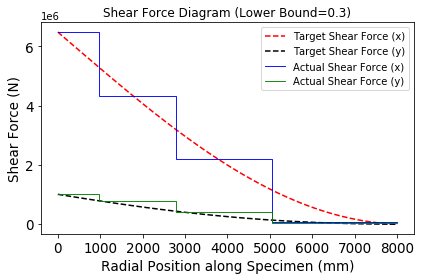

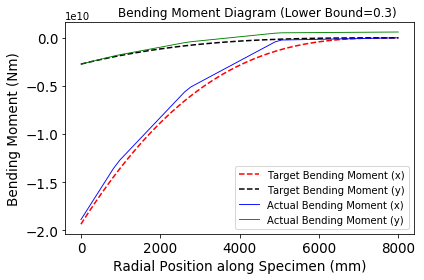

In [11]:
ActualSheary, ActualShearx = AcSh2D(n)
ActualBendingy, ActualBendingx = AcBe(ActualSheary, ActualShearx)


size= 13.5

plt.plot(x, TargetSheary,'r', label = 'Target Shear Force (x)',ls='--')
plt.plot(x, TargetShearx,'black', label = 'Target Shear Force (y)',ls='--')
plt.step(x, ActualSheary,'b', label = 'Actual Shear Force (x)', where='post',lw=0.9)
plt.step(x, ActualShearx,'g', label = 'Actual Shear Force (y)', where='post',lw=0.9)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('Radial Position along Specimen (mm)',fontsize=size)
plt.tick_params(axis='both', which='major', labelsize=13.5)
plt.ylabel('Shear Force (N)',fontsize=size)
plt.title('Shear Force Diagram (Lower Bound=0.3)')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('ShearForceDiagram2D.png')
plt.show()


plt.plot(x,TargetBendingy, 'r', label = 'Target Bending Moment (x)',ls='--')
plt.plot(x,TargetBendingx, 'black',label = 'Target Bending Moment (y)',ls='--')
plt.plot(x, ActualBendingy, 'b', label = 'Actual Bending Moment (x)',lw=0.9)
plt.plot(x, ActualBendingx, 'g', label = 'Actual Bending Moment (y)',lw=0.9)
plt.tick_params(axis='both', which='major', labelsize=13.5)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('Radial Position along Specimen (mm)',fontsize=size)
plt.ylabel('Bending Moment (Nm)',fontsize=size)
plt.title('Bending Moment Diagram (Lower Bound=0.3)',x=.55)
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('BendingMomentDiagram2D.png')
plt.show()

# Exporting to Excel

In [12]:
import pandas as pd
d = {'Nodes':x,'TargetShearx':TargetShearx,'ActualShearx':ActualShearx, 'TargetSheary': TargetSheary,'ActualSheary':ActualSheary, 'TargetBendingx':TargetBendingx,'ActualBendingx':ActualBendingx, 'TargetBendingy':TargetBendingy,'ActualBendingy':ActualBendingy}
df = pd.DataFrame(data=d)

d2={'Angles': angles, 'Positions':positions}
df2=pd.DataFrame(data=d2)

writer = pd.ExcelWriter('Results.xlsx')

df2.to_excel(writer,sheet_name='Solution',index=False)
df.to_excel(writer, sheet_name='Output',index=False)
writer.save()
writer.close()